<a href="https://colab.research.google.com/github/Lucius-40/Computer-Vision-Projects/blob/main/CIFAR-10/Object_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Will try to classify objects from the cifar-10 dataset

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
# Check GPU availability
torch.cuda.is_available()


False

Define the transformation :

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

Loading the dataset :

In [10]:
train_set = torchvision.datasets.CIFAR10(root='.', train=True,download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='.', train=False , download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False)


Looking at random samples of teh dataset :

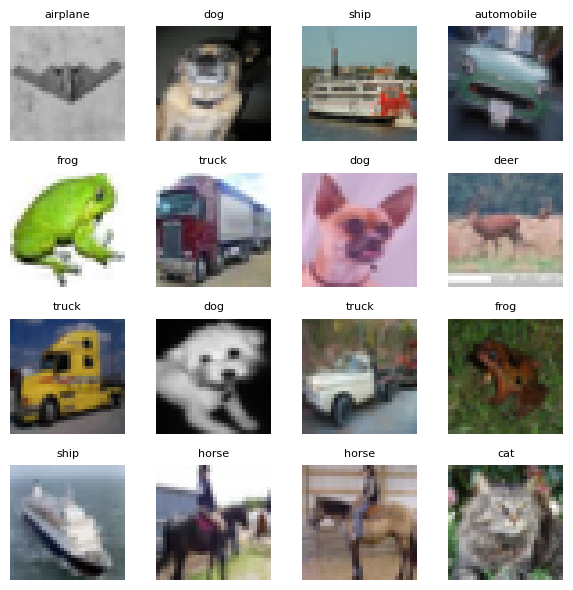

In [12]:

# Unnormalize
def unnormalize(img):
    img = img / 2 + 0.5
    return img.numpy()

# Get 16 random images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images[:16]

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    img = unnormalize(images[i])
    img = np.transpose(img, (1, 2, 0))
    ax.imshow(img)
    ax.set_title(train_set.classes[labels[i]], fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


